# Nota Importante
O propósito deste notebook é determinar se devemos seguir com ou sem os outliers para a criação do nosso melhor modelo. E avaliar se de fato devemos seguir em frente, comparando com simplesmente utilizar a média.

A partir dessa definição, vamos ter outras etapas onde melhoraremos as estratégias dos modelos sobre a base selecionada.

Leia o arquivo [README.md](../README.md) para detalhes sobre a base o projeto.

Leia o arquivo de [01_dicionario_de_dados.md](../referencias/01_dicionario_de_dados.md) para detalhes sobre a base.

Ao importar esse arquivo [src.graficos](./src/graficos.py), em tema seaborn é aplicado.

# Imports e configurações

In [1]:
import pandas as pd

from sklearn.compose import ColumnTransformer # constrói um pipeline para diferentes colunas
from sklearn.dummy import DummyRegressor # modelo de regressão que faz previsões usando estatísticas simples (mean, median, quantile)
from sklearn.linear_model import (
    LinearRegression, # modelo de regressão linear com coeficientes estimados usando o método dos mínimos quadrados
)
from sklearn.preprocessing import ( # pré-processamento de dados
    OrdinalEncoder, # codifica variáveis categóricas com ordenação para valores inteiros
    OneHotEncoder, # codifica variáveis categóricas sem ordenação para uma matriz binária
    PowerTransformer, # aplica uma transformação de potência para estabilizar a variância
)

from src.auxiliares import fnc_exibir_dataframe_resultados
from src.config import  DADOS_COMPLETOS, DADOS_LIMPOS
from src.graficos import (
    PALETTE_TEMPERATURA,
    plot_comparar_metricas_modelos, # função para plotar boxplots de diferentes modelos para diferentes méticas de um dataframe de resultado
)
from src.models import (
    fnc_treinar_e_validar_modelos_regressao, # função para treinar modelos de regressão únicos com validação cruzada
)

In [2]:
pd.options.display.max_rows = 15
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.2f}'.format

# Modelagem inicial - Com Outliers

## Carregando o arquivo completo - Com outliers

Origem: [01-ild-eda.ipynb](01-ild-eda.ipynb)

- `median_income`: renda mediana no grupo de blocos (em dezenas de milhares de dólares)
- `housing_median_age`: idade mediana das casas no grupo de blocos
- `total_rooms`: número cômodos no grupo de blocos
- `total_bedrooms`: número de quartos no grupo de blocos
- `population`: população do grupo de blocos
- `households`: domicílios no grupo de blocos
- `latitude`: latitude do grupo de blocos
- `longitude`: longitude do grupo de blocos
- `ocean_proximity`: proximidade do oceano
  - `NEAR BAY`: perto da baía
  - `<1H OCEAN`: a menos de uma hora do oceano
  - `INLAND`: no interior
  - `NEAR OCEAN`: perto do oceano
- `median_house_value`: valor mediano das casas no grupo de blocos (em dólares)
- `median_income_cat`: categorias baseadas no valor da mediana do salário anual -> `median_income`
- `housing_median_age_cat`: categorias baseadas no valor da mediana das idades das casas -> `housing_median_age`
- `population_cat`: categorias baseadas no tamanho da população -> `population`
- `rooms_per_household`: `total_rooms` / `households`
- `population_per_household`: `population` / `households`
- `bedrooms_per_room`: `total_bedrooms` / `total_rooms`

In [3]:
# dados completos são os dados com outliers
df = pd.read_parquet(DADOS_COMPLETOS)

In [4]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,housing_median_age_cat,population_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.23,37.88,41,880,129,322,126,8.33,452600,NEAR BAY,6 <= x,40 <= x,0 <= x < 500,6.98,2.56,0.15
1,-122.22,37.86,21,7099,1106,2401,1138,8.30,358500,NEAR BAY,6 <= x,20 <= x < 30,2000 <= x,6.24,2.11,0.16
2,-122.24,37.85,52,1467,190,496,177,7.26,352100,NEAR BAY,6 <= x,40 <= x,0 <= x < 500,8.29,2.80,0.13
3,-122.25,37.85,52,1274,235,558,219,5.64,341300,NEAR BAY,4.5 <= x < 6,40 <= x,500 <= x < 1000,5.82,2.55,0.18
4,-122.25,37.85,52,1627,280,565,259,3.85,342200,NEAR BAY,3 <= x < 4.5,40 <= x,500 <= x < 1000,6.28,2.18,0.17


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20428 entries, 0 to 20427
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 20428 non-null  float32 
 1   latitude                  20428 non-null  float32 
 2   housing_median_age        20428 non-null  uint8   
 3   total_rooms               20428 non-null  uint16  
 4   total_bedrooms            20428 non-null  uint16  
 5   population                20428 non-null  uint16  
 6   households                20428 non-null  uint16  
 7   median_income             20428 non-null  float32 
 8   median_house_value        20428 non-null  uint32  
 9   ocean_proximity           20428 non-null  category
 10  median_income_cat         20428 non-null  category
 11  housing_median_age_cat    20428 non-null  category
 12  population_cat            20428 non-null  category
 13  rooms_per_household       20428 non-null  floa

## Definindo as estratégias para os modelos

In [6]:
# define as colunas a serem transformadas 
colunas_one_hot_encoder = ['ocean_proximity',]
colunas_ordinal_encoder = ['median_income_cat', 'housing_median_age_cat', 'population_cat',]


# define o preprocessamento das colunas - o preprocessamento é feito em ordem
preprocessamento = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first'), colunas_one_hot_encoder), # drop='first' para evitar a dummy variable trap
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), colunas_ordinal_encoder), # categories='auto' para usar as categorias do dataframe
    ],
    remainder='passthrough', # mantém as colunas que não foram transformadas
)

# define a transformação da variável target - a transformação é feita para estabilizar a variância
target_transformer = PowerTransformer()

# define os modelos a serem testados - cada modelo é um dicionário com as chaves 'preprocessor', 'regressor' e 'target_transformer'
regressors = {
    'DummyRegressor': {
        'preprocessor': None,
        'regressor': DummyRegressor(strategy='mean'),
        'target_transformer': None,
    },
    'LinearRegression': {
        'preprocessor': preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': None,
    },
    'LinearRegression_target': {
        'preprocessor': preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': target_transformer,
    },
}


# algorítmos de avaliação de modelos de regressão a utilizar nessa análise - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
dct_metricas_modelos = {
        # 'd2_absolute_error_score'            : 'd2ae',  # melhor = 1.0 -> metrics.d2_absolute_error_score
        # 'explained_variance'                 : 'evs',   # melhor = 1.0 -> metrics.explained_variance_score
        # 'neg_max_error'                      : 'maxe',  # melhor = 0.0 -> metrics.max_error
        'neg_mean_absolute_error'            : 'mae',   # melhor = 0.0 -> metrics.mean_absolute_error
        # 'neg_mean_absolute_percentage_error' : 'mape',  # melhor = 0.0 -> metrics.mean_absolute_percentage_error
        # 'neg_mean_gamma_deviance'            : 'mgd',   # melhor = 0.0 -> metrics.mean_gamma_deviance
        # 'neg_mean_poisson_deviance'          : 'mpd',   # melhor = 0.0 -> metrics.mean_poisson_deviance
        # 'neg_mean_squared_error'             : 'mse',   # melhor = 0.0 -> metrics.mean_squared_error
        # 'neg_mean_squared_log_error'         : 'msle',  # melhor = 0.0 -> metrics.mean_squared_log_error
        # 'neg_median_absolute_error'          : 'medae', # melhor = 0.0 -> metrics.median_absolute_error
        'neg_root_mean_squared_error'        : 'rmse',  # melhor = 0.0 -> metrics.root_mean_squared_error
        # 'neg_root_mean_squared_log_error'    : 'rmsle', # melhor = 0.0 -> metrics.root_mean_squared_log_error
        'r2'                                 : 'r2',    # melhor = 1.0 -> metrics.r2_score
}


## Separando a coluna target

In [7]:
coluna_target = ['median_house_value']

X = df.drop(columns=coluna_target)
y = df[coluna_target]

display(X.head(), y.head())

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,housing_median_age_cat,population_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.23,37.88,41,880,129,322,126,8.33,NEAR BAY,6 <= x,40 <= x,0 <= x < 500,6.98,2.56,0.15
1,-122.22,37.86,21,7099,1106,2401,1138,8.30,NEAR BAY,6 <= x,20 <= x < 30,2000 <= x,6.24,2.11,0.16
2,-122.24,37.85,52,1467,190,496,177,7.26,NEAR BAY,6 <= x,40 <= x,0 <= x < 500,8.29,2.80,0.13
3,-122.25,37.85,52,1274,235,558,219,5.64,NEAR BAY,4.5 <= x < 6,40 <= x,500 <= x < 1000,5.82,2.55,0.18
4,-122.25,37.85,52,1627,280,565,259,3.85,NEAR BAY,3 <= x < 4.5,40 <= x,500 <= x < 1000,6.28,2.18,0.17


,median_house_value
0,452600
1,358500
2,352100
3,341300
4,342200


## Treinando e avaliando os modelos conforme a estratégia definida acima

In [8]:
df_resultados = fnc_treinar_e_validar_modelos_regressao(
    X=X,
    y=y,
    regressors=regressors,
    scoring=tuple(dct_metricas_modelos.keys()),
)

fnc_exibir_dataframe_resultados(df_resultados)

Index(['model', 'fit_time', 'score_time', 'test_neg_mean_absolute_error',
       'test_neg_root_mean_squared_error', 'test_r2', 'time_seconds'],
      dtype='object')


,model,fit_time,score_time,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_r2,time_seconds
0,DummyRegressor,0.009819,0.011577,-90912.747875,-115292.550715,-0.000263,0.021396
1,DummyRegressor,0.007219,0.007983,-90861.611408,-114251.739545,-0.001474,0.015202
2,DummyRegressor,0.006115,0.007736,-92207.442090,-116720.909547,-0.000058,0.013851
3,DummyRegressor,0.007854,0.010306,-90091.219272,-114592.132037,-0.000238,0.018159
4,DummyRegressor,0.007048,0.007166,-91796.036026,-116212.794722,-0.000002,0.014214
5,LinearRegression,0.174803,0.036327,-49547.845409,-67581.869260,0.656306,0.211130
6,LinearRegression,0.094243,0.023484,-48164.651281,-67192.144067,0.653621,0.117727
7,LinearRegression,0.038944,0.013478,-50699.117531,-70773.552967,0.632320,0.052422
8,LinearRegression,0.034787,0.013340,-48361.607711,-65829.230266,0.669911,0.048127
9,LinearRegression,0.034145,0.012877,-48866.496839,-67575.165244,0.661883,0.047021


In [9]:
fnc_exibir_dataframe_resultados(df_resultados.groupby('model').mean())

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_r2,time_seconds
model,,,,,,
DummyRegressor,0.007611,0.008953,-91173.811334,-115414.025313,-0.000407,0.016564
LinearRegression,0.075384,0.019901,-49127.943754,-67790.392361,0.654808,0.095285
LinearRegression_target,0.064914,0.015777,-47303.753755,-70117.419149,0.630662,0.080691


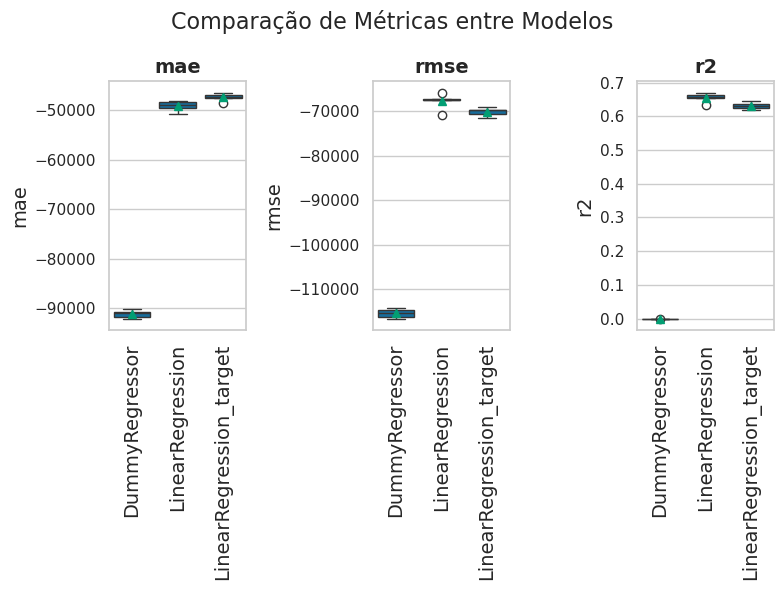

In [10]:
plot_comparar_metricas_modelos(
    df_resultados=df_resultados,
    comparar_metricas=['test_' + metrica for metrica in dct_metricas_modelos.keys()],
    nomes_metricas=dct_metricas_modelos.values(),
    figsize=(8, 6),
    colunas_graficos=3,
    flg_boxplots_horizontais=False,
)

## Considerações/Observações sobre o primeiro modelo - Com Outliers

- Claramente o conjunto dados permite construir um modelo melhor que simplemente usar ao média dos dados [DummyRegressor], então podemos seguir com novas estratégias para chegar no melhor modelo;
- `LinearRegression` se mostrou inicialmente melhor sem transformações no target no `RMSE` e no `R²`. O contrário no `MAE`;

Isso ainda é uma primeira versão/avaliação, apenas para comparar com a base sem outliers, para definir o melhor conjunto de dados para seguir com os demais modelos.

Faremos o mesmo processo a seguir com os dados [sem ouliters] e no final escolher a melhor base para as próximas etapas/modelos/estratégias.

# Modelagem inicial - Sem Ouliers
## Carregando o arquivo completo - Sem outliers


In [11]:
# dados completos são os dados com outliers
df = pd.read_parquet(DADOS_LIMPOS)

In [12]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,housing_median_age_cat,population_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.23,37.88,41,880,129,322,126,8.33,452600,NEAR BAY,6 <= x,40 <= x,0 <= x < 500,6.98,2.56,0.15
1,-122.22,37.86,21,7099,1106,2401,1138,8.30,358500,NEAR BAY,6 <= x,20 <= x < 30,2000 <= x,6.24,2.11,0.16
2,-122.26,37.84,42,2555,665,1206,595,2.08,226700,NEAR BAY,1.5 <= x < 3,40 <= x,1000 <= x < 1500,4.29,2.03,0.26
3,-122.26,37.85,50,1120,283,697,264,2.12,140000,NEAR BAY,1.5 <= x < 3,40 <= x,500 <= x < 1000,4.24,2.64,0.25
4,-122.26,37.84,50,2239,455,990,419,1.99,158700,NEAR BAY,1.5 <= x < 3,40 <= x,500 <= x < 1000,5.34,2.36,0.20


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18375 entries, 0 to 18374
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 18375 non-null  float32 
 1   latitude                  18375 non-null  float32 
 2   housing_median_age        18375 non-null  uint8   
 3   total_rooms               18375 non-null  uint16  
 4   total_bedrooms            18375 non-null  uint16  
 5   population                18375 non-null  uint16  
 6   households                18375 non-null  uint16  
 7   median_income             18375 non-null  float32 
 8   median_house_value        18375 non-null  uint32  
 9   ocean_proximity           18375 non-null  category
 10  median_income_cat         18375 non-null  category
 11  housing_median_age_cat    18375 non-null  category
 12  population_cat            18375 non-null  category
 13  rooms_per_household       18375 non-null  floa

## Separando a coluna target

In [14]:
X = df.drop(columns=coluna_target)
y = df[coluna_target]

display(X.head(), y.head())

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,housing_median_age_cat,population_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.23,37.88,41,880,129,322,126,8.33,NEAR BAY,6 <= x,40 <= x,0 <= x < 500,6.98,2.56,0.15
1,-122.22,37.86,21,7099,1106,2401,1138,8.30,NEAR BAY,6 <= x,20 <= x < 30,2000 <= x,6.24,2.11,0.16
2,-122.26,37.84,42,2555,665,1206,595,2.08,NEAR BAY,1.5 <= x < 3,40 <= x,1000 <= x < 1500,4.29,2.03,0.26
3,-122.26,37.85,50,1120,283,697,264,2.12,NEAR BAY,1.5 <= x < 3,40 <= x,500 <= x < 1000,4.24,2.64,0.25
4,-122.26,37.84,50,2239,455,990,419,1.99,NEAR BAY,1.5 <= x < 3,40 <= x,500 <= x < 1000,5.34,2.36,0.20


,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


## Treinando e avaliando os modelos conforme a estratégia definida acima

In [15]:
df_resultados = fnc_treinar_e_validar_modelos_regressao(
    X=X,
    y=y,
    regressors=regressors,
    scoring=tuple(dct_metricas_modelos.keys()),
)

fnc_exibir_dataframe_resultados(df_resultados)

Index(['model', 'fit_time', 'score_time', 'test_neg_mean_absolute_error',
       'test_neg_root_mean_squared_error', 'test_r2', 'time_seconds'],
      dtype='object')


,model,fit_time,score_time,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_r2,time_seconds
0,DummyRegressor,0.008797,0.011178,-76364.022230,-95672.363984,-0.000020,0.019975
1,DummyRegressor,0.006097,0.004252,-76793.153163,-96058.341672,-0.000083,0.010350
2,DummyRegressor,0.004850,0.004505,-76511.108847,-96904.577781,-0.000406,0.009356
3,DummyRegressor,0.003151,0.005098,-74870.206173,-93752.845664,-0.000546,0.008249
4,DummyRegressor,0.003767,0.004255,-77256.502400,-96248.809537,-0.000051,0.008021
5,LinearRegression,0.033896,0.013494,-42608.548594,-57885.459811,0.633921,0.047390
6,LinearRegression,0.034074,0.013752,-43656.721166,-60277.610534,0.606198,0.047826
7,LinearRegression,0.033776,0.013654,-42680.676691,-58760.134507,0.632165,0.047429
8,LinearRegression,0.036162,0.013351,-41359.255392,-55976.927158,0.643314,0.049513
9,LinearRegression,0.034036,0.013399,-41678.631192,-57878.822150,0.638365,0.047434


In [16]:
fnc_exibir_dataframe_resultados(df_resultados.groupby('model').mean())

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_r2,time_seconds
model,,,,,,
DummyRegressor,0.005332,0.005858,-76358.998563,-95727.387728,-0.000221,0.011190
LinearRegression,0.034389,0.013530,-42396.766607,-58155.790832,0.630792,0.047918
LinearRegression_target,0.057728,0.014426,-40946.268978,-58678.638587,0.624037,0.072155


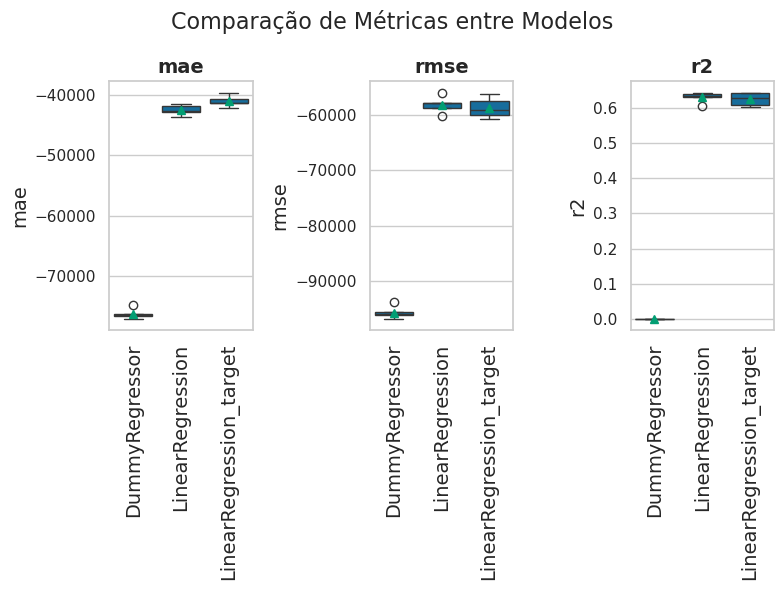

In [17]:
plot_comparar_metricas_modelos(
    df_resultados=df_resultados,
    comparar_metricas=['test_' + metrica for metrica in dct_metricas_modelos.keys()],
    nomes_metricas=dct_metricas_modelos.values(),
    figsize=(8, 6),
    colunas_graficos=3,
    flg_boxplots_horizontais=False,
)

## Considerações/Observações sobre o primeiro modelo - Sem Outliers

- Assim como na versão com outliers, claramente o conjunto dados permite construir um modelo melhor que simplemente usar ao média dos dados [DummyRegressor], então podemos seguir com novas estratégias para chegar no melhor modelo;
- `LinearRegression` se mostrou inicialmente melhor sem transformações no target no `RMSE` e no `R²`. O contrário no `MAE`, assim como já visto na base com ouliers;

# Escolhendo entre a base com e sem Outliers

- A base [SEM Outliers] apresenta melhores valores para `MAE` e `RMSE` em diferença bastante relevante.
- A base [COM Outliers] apresenta melhor valor no `R²`, mas com uma diferença muito próxima.

MAE e RMSE são geralmente melhores para avaliar a precisão do modelo em termos de erro real, enquanto o R² pode ser útil para entender a capacidade de explicação do modelo.

Considerando esses informações, vamos utilizar a base [SEM Outliers] nos modelos que serão gerados nas próximas etapas, com o objetivo de obter o melhor modelo de regressão para nosso conjunto de dados.